In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})
import scipy.interpolate

In [2]:
kvec = [1e-1,1,1e1]
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
mv_test = 0.3 
H0 = 67 / (3*1e5) # i 1/Mpc

cosmo_dict ={'H0':70,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }

cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()

pts = cosmo.get_perturbations()['scalar']
print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]

mv = mv_test * 1e-6

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [24]:
x = 5
k_ind = 1
k = kvec[k_ind]
T_ini = x / k
# cs front faktoren
factor = 1e-1#2.68


# udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv,factor):
    return factor * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
tau = sol_tau.y[0]

sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
a_tau = sol_a.t
a = sol_a.y[0]

a_interp = scipy.interpolate.interp1d(a_tau,a)

# sammenlignings data fra Class

delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)


Text(0.5, 1.0, 'Class løsninger for cdm og neutrinoer for k = 1 og x = 5')

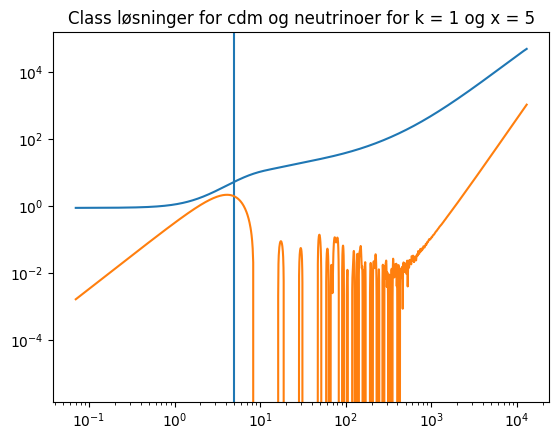

In [25]:
plt.loglog(tau_class,-delta_class)
plt.axvline(T_ini)
plt.loglog(tau_class,-delta_neutrino_class)
plt.title("Class løsninger for cdm og neutrinoer for k = %s og x = %s" %(k,x))

# Metode  1 - fra den første artikel

ligninger 

for $\delta_{cdm}$

$\dot{\delta}_{cdm} = - \theta_{cdm}$

$\dot{\theta}_{cdm} = - \mathcal{H}a\theta_{cdm} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm}$

baseret på https://arxiv.org/abs/1602.05933 med e ekstra faktor a på $\mathcal{H}$ i $\dot{\theta}_{cdm}$

ved neutrinoer er $\dot{\delta}$ den samme.

$\dot{\theta}_{\nu}   =  -\mathcal{H}a\theta_{\nu} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm} + k^2  cs^2 \delta_{\nu}$


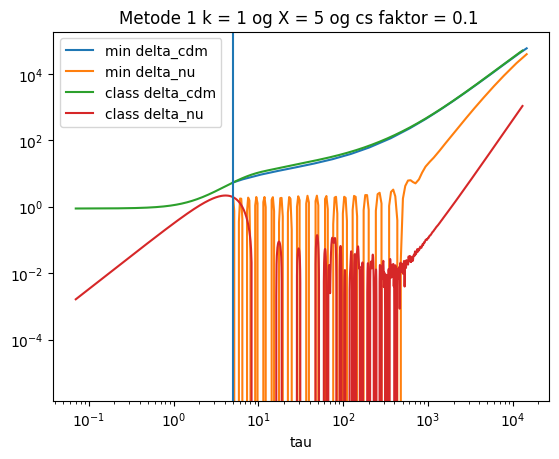

In [26]:
t_span = [T_ini,tau[-1]]


def cdm_func1(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init,theta_init]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp1 = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp1(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init,theta_neutrino_init]

sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]

plt.loglog(t_cdm1,-delta_cdm1,label="min delta_cdm")
plt.loglog(t_nue1,-delta_neu1,label="min delta_nu")
plt.loglog(tau_class,-delta_class,label="class delta_cdm")
plt.loglog(tau_class,-delta_neutrino_class,label="class delta_nu")
plt.axvline(T_ini)
plt.xlabel("tau")
plt.title("Metode 1 k = %s og X = %s og cs faktor = %s " %(k,x,factor))
plt.legend()

# Metode 2 - hybrid - er lidt beskidt (jeg blander lignigner) men den virker overraskende godt
ligninger 

for $\delta_{cdm}$

$\dot{\delta}_{cdm} = - \theta_{cdm}$

$\dot{\theta}_{cdm} = - \mathcal{H}a\theta_{cdm} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm}$

baseret på https://arxiv.org/abs/1602.05933 og https://arxiv.org/pdf/1408.2995.pdf med e ekstra faktor a på $\mathcal{H}$ i $\dot{\theta}_{cdm}$

ved neutrinoer er $\dot{\delta}$ den samme.

$\dot{\theta}_{\nu}   =  -\mathcal{H}a\theta_{\nu} - \frac{3}{2}\mathcal{H}^2a^2 \Omega_M \delta_{cdm} + k^2  cs^2 \delta_{\nu}$


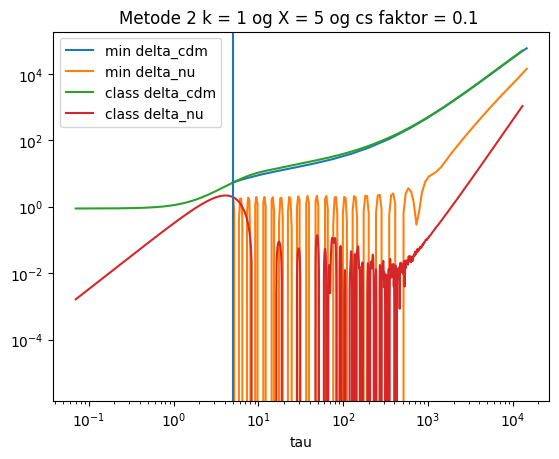

In [27]:
t_span = [T_ini,tau[-1]]


def cdm_func2(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    d_theta   = -  H(a)*a * theta - 3/2 * H0**2 * Omega_M * delta /a
    return [d_delta,d_theta]

y02 = [delta_init,theta_init]

sol_cdm2 = sc.solve_ivp(cdm_func2, t_span = t_span, y0 = y02)

t_cdm2 = sol_cdm2.t
delta_cdm2 = sol_cdm2.y[0]


delta_cdm_interp2 = scipy.interpolate.interp1d(t_cdm2,delta_cdm2)

def neu_func2(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp2(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H(a)*a *H(a)*a  * Omega_M * delta_cdm  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y02_neutrino = [delta_neutrino_init,theta_neutrino_init]

sol_neu2 = sc.solve_ivp(neu_func2,
                        t_span = t_span,
                        y0 = y02_neutrino,
                        args=(k,mv,factor))

t_nue2 = sol_neu2.t
delta_neu2 = sol_neu2.y[0]

plt.loglog(t_cdm2,-delta_cdm2,label="min delta_cdm")
plt.loglog(t_nue2,-delta_neu2,label="min delta_nu")
plt.loglog(tau_class,-delta_class,label="class delta_cdm")
plt.loglog(tau_class,-delta_neutrino_class,label="class delta_nu")
plt.axvline(T_ini)
plt.xlabel("tau")
plt.title("Metode 2 k = %s og X = %s og cs faktor = %s " %(k,x,factor))
plt.legend()

# Metode 3

ligninger 

for $\delta_{cdm}$

$\dot{\delta}_{cdm} = - \theta_{cdm}$

$\dot{\theta}_{cdm} = - \mathcal{H}a\theta_{cdm} - \frac{3}{2} \mathcal{H}^2a ^2 \Omega_M \delta_{cdm}$

baseret på https://arxiv.org/pdf/1408.2995.pdf med e ekstra faktor a på alle $\mathcal{H}$ 

ved neutrinoer er $\dot{\delta}$ den samme.

$\dot{\theta}_{\nu}   =  -\mathcal{H}a\theta_{\nu} - \frac{3}{2}\mathcal{H}^2a^2 \Omega_M \delta_{cdm} + k^2  cs^2 \delta_{\nu}$


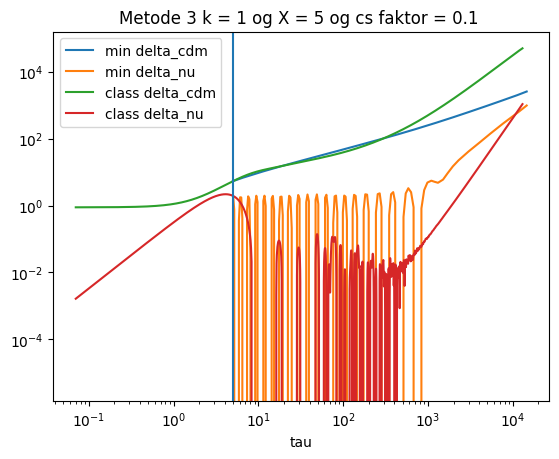

In [28]:
t_span = [T_ini,tau[-1]]

def cdm_func3(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    d_theta   = -  H(a)*a * theta - 3/2 * H(a)*a * H(a)*a * Omega_M * delta 
    return [d_delta,d_theta]

y03 = [delta_init,theta_init]

sol_cdm3 = sc.solve_ivp(cdm_func3, t_span = t_span, y0 = y03)

t_cdm3 = sol_cdm3.t
delta_cdm3 = sol_cdm3.y[0]


delta_cdm_interp3 = scipy.interpolate.interp1d(t_cdm3,delta_cdm3)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func3(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp3(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H(a)*a *H(a)*a  * Omega_M * delta_cdm  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y03_neutrino = [delta_neutrino_init,theta_neutrino_init]

sol_neu3 = sc.solve_ivp(neu_func3, t_span = t_span, y0 = y03_neutrino,args=(k,mv,factor))

t_nue3 = sol_neu3.t
delta_neu3 = sol_neu3.y[0]

plt.loglog(t_cdm3,-delta_cdm3,label="min delta_cdm")
plt.loglog(t_nue3,-delta_neu3,label="min delta_nu")
plt.loglog(tau_class,-delta_class,label="class delta_cdm")
plt.loglog(tau_class,-delta_neutrino_class,label="class delta_nu")
plt.axvline(T_ini)
plt.xlabel("tau")
plt.title("Metode 3 k = %s og X = %s og cs faktor = %s " %(k,x,factor))
plt.legend(loc="upper left")

# Metode 4 - giver runtime error - overfow


ligninger 

for $\delta_{cdm}$

$\dot{\delta}_{cdm} = - \theta_{cdm}$

$\dot{\theta}_{cdm} = - \mathcal{H}a\theta_{cdm} - \frac{3}{2} \mathcal{H}^2a ^2 \Omega_M \delta_{cdm}$

baseret på https://arxiv.org/pdf/1408.2995.pdf uden ekstra faktor a på alle $\mathcal{H}$ 

ved neutrinoer er $\dot{\delta}$ den samme.

$\dot{\theta}_{\nu}   =  -\mathcal{H}a\theta_{\nu} - \frac{3}{2}\mathcal{H}^2a^2 \Omega_M \delta_{cdm} + k^2  cs^2 \delta_{\nu}$

In [29]:
"""t_span = [T_ini,tau[-1]]


def cdm_func4(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    d_theta   = -  H(a) * theta - 3/2 * H(a)**2 * Omega_M * delta 
    return [d_delta,d_theta]

y04 = [delta_init,theta_init]

sol_cdm4 = sc.solve_ivp(cdm_func4, t_span = t_span, y0 = y01)

t_cdm4 = sol_cdm4.t
delta_cdm4 = sol_cdm4.y[0]


delta_cdm_interp4 = scipy.interpolate.interp1d(t_cdm4,delta_cdm4)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func4(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp4(t)
    d_theta   =  -  H(a) * theta - (3/2) * H(a) ** 2  * Omega_M * delta_cdm  + k ** 2 * cs(a,mv,factor) * delta
    return [d_delta,d_theta]


y04_neutrino = [delta_neutrino_init,theta_neutrino_init]

sol_neu4 = sc.solve_ivp(neu_func4, t_span = t_span, y0 = y04_neutrino,args=(k,mv,factor))

t_nue4 = sol_neu4.t
delta_neu4 = sol_neu4.y[0]

plt.loglog(t_cdm4,-delta_cdm4,label="min delta_cdm")
plt.loglog(t_nue4,-delta_neu4,label="min delta_neu")
plt.loglog(tau_class,-delta_class,label="class delta_cdm")
plt.loglog(tau_class,-delta_neutrino_class,label="class delta_neu")
plt.axvline(T_ini)
plt.xlabel("tau")
plt.title("Metode 4 k = %s og X = %s og cs faktor = %s " %(k,x,factor))
plt.legend(loc="upper left")"""

't_span = [T_ini,tau[-1]]\n\n\ndef cdm_func4(t,y):\n    delta = y[0]\n    theta = y[1]    \n    a = a_interp(t)\n    d_delta   = - theta\n    d_theta   = -  H(a) * theta - 3/2 * H(a)**2 * Omega_M * delta \n    return [d_delta,d_theta]\n\ny04 = [delta_init,theta_init]\n\nsol_cdm4 = sc.solve_ivp(cdm_func4, t_span = t_span, y0 = y01)\n\nt_cdm4 = sol_cdm4.t\ndelta_cdm4 = sol_cdm4.y[0]\n\n\ndelta_cdm_interp4 = scipy.interpolate.interp1d(t_cdm4,delta_cdm4)\n\ndef cs(a,mv,factor):\n    return factor * Tv(a) / mv\n\ndef neu_func4(t,y,k,mv,factor):\n    delta = y[0]\n    theta = y[1]    \n    a = a_interp(t)\n    d_delta   = - theta\n    delta_cdm = delta_cdm_interp4(t)\n    d_theta   =  -  H(a) * theta - (3/2) * H(a) ** 2  * Omega_M * delta_cdm  + k ** 2 * cs(a,mv,factor) * delta\n    return [d_delta,d_theta]\n\n\ny04_neutrino = [delta_neutrino_init,theta_neutrino_init]\n\nsol_neu4 = sc.solve_ivp(neu_func4, t_span = t_span, y0 = y04_neutrino,args=(k,mv,factor))\n\nt_nue4 = sol_neu4.t\ndelta_ne

# Metode 5 - growth func.


baseret på ligning $(2.9)$ i  https://arxiv.org/abs/1602.05933

Hvor et ekstra $ k^2  cs^2 \delta_{\nu}$ term er blevet smidt ind i neutrino growth funktionen.


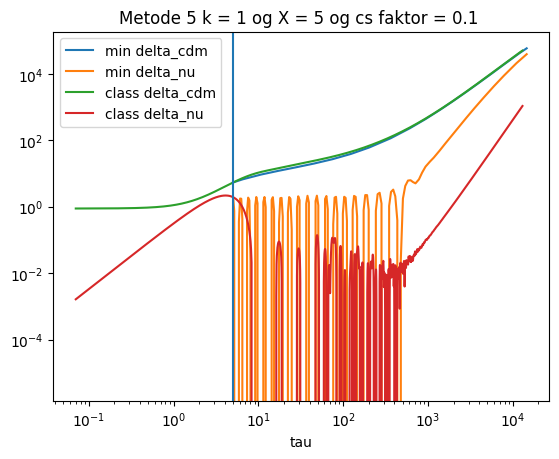

In [30]:
t_span = [T_ini,tau[-1]]

def cdm_func5(t,y):
    delta = y[0]
    d_delta = y[1]    
    a = a_interp(t)
    d2_delta = -(- (3/2) * H0*H0 * Omega_M * delta / a -  H(a) * (-d_delta) * a)
    return [d_delta,d2_delta]


y05 = [delta_init,-theta_init]

sol_cdm5 = sc.solve_ivp(cdm_func5, t_span = t_span, y0 = y05)

t_cdm5 = sol_cdm5.t
delta_cdm5 = sol_cdm5.y[0]


delta_cdm_interp5 = scipy.interpolate.interp1d(t_cdm5,delta_cdm5)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func5(t,y,k,mv,factor):
    delta = y[0]
    d_delta = y[1]    
    a = a_interp(t)
    delta_cdm = delta_cdm_interp5(t)
    d2_delta   =  -(-  H(a) * a * (-d_delta) - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor) **2 * delta)
    return [d_delta,d2_delta]


y05_neutrino = [delta_neutrino_init,-theta_neutrino_init]

sol_neu5 = sc.solve_ivp(neu_func5, t_span = t_span, y0 = y05_neutrino,args=(k,mv,factor))

t_nue5 = sol_neu5.t
delta_neu5 = sol_neu5.y[0]

plt.loglog(t_cdm5,-delta_cdm5,label="min delta_cdm")
plt.loglog(t_nue5,-delta_neu5,label="min delta_nu")
plt.loglog(tau_class,-delta_class,label="class delta_cdm")
plt.loglog(tau_class,-delta_neutrino_class,label="class delta_nu")
plt.axvline(T_ini)
plt.xlabel("tau")
plt.title("Metode 5 k = %s og X = %s og cs faktor = %s " %(k,x,factor))
plt.legend()